In [1]:
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import skimage.io as io


# confidence Threshold 설정
CONF_THR = 0.7

# 사용할 fold num 설정
fold_num = 3
train_json_path = f'../dataset2/stratified_kfold/cv_train_{fold_num}.json'

# test.json inference한 결과 경로 설정
submission_path = '../work_dirs/autoassign_swin_l_fpn/submission_best_bbox_mAP_50_epoch_12.csv'

# 결과물이 저장될 root와 이름 설정
output_root = '../dataset2'
output_json_name = 'pseudo_train'
output_path = os.path.join(output_root,output_json_name + '.json',)

# ---------------------------------------------------------------------------------------------------------------- #

with open(train_json_path) as f:
    train_json = json.load(f)

df = pd.read_csv(submission_path)
submission_list = df.values.tolist()

images = []
annotations = []

start_id = train_json['images'][-1]['id']
start_anno_id = train_json['annotations'][-1]['id']

print('pseudo labeling start...')

for bboxes, image_name in submission_list:
    # image
    start_id += 1
    bboxes_splited = bboxes.split()
    num_bbox = 0
    
    for i in range(6, len(bboxes_splited)+1, 6):
        bbox = bboxes_splited[i-6:i]
        _class, conf, left, top, right, bottom = bbox[0], float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]), float(bbox[5])
        width, height = right - left, bottom - top
        area = round(width * height, 2)

        if conf < CONF_THR:
            continue
        start_anno_id += 1
        num_bbox += 1
        
        annotation = dict()
        annotation['image_id'] = start_id
        annotation['category_id'] = _class
        annotation['area'] = area
        annotation['bbox'] = [round(left, 1), round(top, 1), round(width, 1), round(height, 1)]
        annotation['iscrowd'] = 0
        annotation['id'] = start_anno_id
        annotations.append(annotation)

    if num_bbox != 0:
        image = dict()
        image['width'] = 1024
        image['height'] = 1024
        image['file_name'] = image_name
        image['license'] = 0
        image['flickr_url'] = None
        image['coco_ur'] = None
        image['date_captured'] = "2020-12-12 15:19:33"
        image['id'] = start_id
        images.append(image)

print('pseudo labeling finished...\n')
print(f'{len(images)}개의 images가 추가되었습니다.')
print(f'{len(annotations)}개의 annotations이 추가되었습니다.\n')

train_json['images'] += images
train_json['annotations'] += annotations

print(f'{output_path} 에 저장되었습니다.')

with open(output_path, 'w') as f:
    json.dump(train_json, f)


pseudo labeling start...
pseudo labeling finished...

4749개의 images가 추가되었습니다.
10785개의 annotations이 추가되었습니다.

../dataset2/pseudo_train.json 에 저장되었습니다.


test/0080.jpg
{'image_id': 4963, 'category_id': '7', 'area': 179452.48, 'bbox': [294.8, 382.2, 428.8, 418.5], 'iscrowd': 0, 'id': 23330}


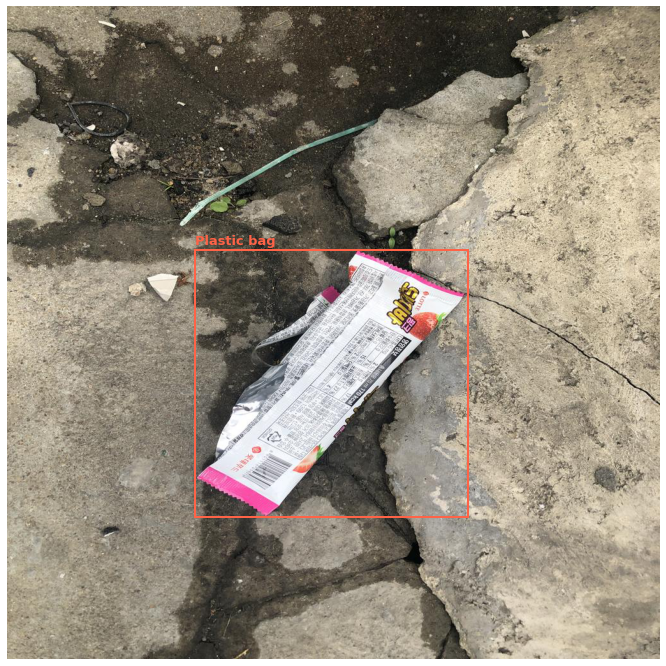

In [3]:
index = random.randrange(len(images))
classes = (
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
)
file_name, id = images[index]['file_name'], images[index]['id']
print(file_name)
I = io.imread(os.path.join('../dataset', file_name))
plt.rcParams["figure.figsize"] = (12,12)
plt.axis('off')
plt.imshow(I)
ax = plt.gca()
for annotation in annotations:
    if id == annotation['image_id']:
        print(annotation)
        box = annotation['bbox']
        bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth = 2, edgecolor = 'tomato',facecolor = 'none')
        ax.add_patch(bb)
        ax.text(box[0], box[1] - 10 , classes[int(annotation['category_id'])], weight = 'bold', color = 'tomato', fontsize = 13)
plt.show()